This notebook perform some analysis on several CLIP models fine-tuned on TinyImageNet.

## Setup Environment

In [1]:
LOCAL = True

if LOCAL:
    ROOT_DIR = "/Users/Yang/Desktop/research-model-merge/playground/merge_soup-clip-tinyImageNet"
    DATA_DIR = "/Users/Yang/Desktop/research-model-merge/datasets"
    PROJECT_ROOT = "/Users/Yang/Desktop/research-model-merge"
    DRIVE_DIR = ROOT_DIR  # Save results locally in the same directory
else:
    # on Colab
    ROOT_DIR = "/content/research-model-merge/playground/merge_soup-clip-tinyImageNet"
    DATA_DIR = "/content/research-model-merge/datasets"
    PROJECT_ROOT = "/content/research-model-merge"
    DRIVE_DIR = "/content/drive/MyDrive/research-model_merge-shared/merge_soup-clip-tinyImageNet"

### Mount Google Drive (Colab only)

In [2]:
if not LOCAL:
    from google.colab import drive
    drive.mount('/content/drive')

### Clone Repository and Install Dependencies (Colab only)

In [3]:
if not LOCAL:
    !rm -rf research-model-merge
    !git clone https://github.com/nbzy1995/research-model-merge.git /content/research-model-merge
    !pip install --quiet --upgrade pip
    !pip install -q -r research-model-merge/requirements.txt
    print("✅ Repository cloned and dependencies installed!")

Now we download tiny imagenet dataset. The cell below will create a directory called "tiny-imagenet-200" containing the dataset.

In [4]:
import os

if not LOCAL:
    if not os.path.exists("tiny-imagenet-200"):
      !wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip
      !unzip -q tiny-imagenet-200.zip
      !mv tiny-imagenet-200 {DATA_DIR}/tiny-imagenet-200

### Import Libraries

In [5]:
import os
import sys
import subprocess
from itertools import combinations

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Add project directories to path
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
if ROOT_DIR not in sys.path:
    sys.path.insert(0, ROOT_DIR)

import clip
from datasets import tiny_imagenet
from utils import ModelWrapper,get_model_from_sd, eval_model_on_dataset

### Check Device Information

In [6]:
print("🔍 System Information:")
print(f"Python version: {subprocess.check_output(['python', '--version']).decode().strip()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU deivce: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("❌ No GPU available! Please enable GPU runtime in Colab.")
    print("Runtime > Change runtime type > Hardware accelerator > GPU")

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

🔍 System Information:
Python version: Python 3.11.5
PyTorch version: 2.3.0
CUDA available: False
❌ No GPU available! Please enable GPU runtime in Colab.
Runtime > Change runtime type > Hardware accelerator > GPU


## Prepare Dataset

In [7]:
print("Creating datasets...")

from datasets.tiny_imagenet import TinyImageNet
from torch.utils.data import Subset

# Use CLIP's expected preprocessing for proper model evaluation
import clip
clip_preprocess = clip.load('ViT-B/32', DEVICE, jit=False)[1]

data_tinyImageNet = TinyImageNet(
    train_preprocess=clip_preprocess,
    eval_preprocess=clip_preprocess,
    location=DATA_DIR,
    batch_size=32,
    num_workers=2,
    distributed=False,
)

# For local testing, let's use a small subset of the data
if LOCAL:
    subset_fraction = 0.001
    
    # Test subset
    num_test_samples = int(len(data_tinyImageNet.test_dataset) * subset_fraction)
    test_subset_indices = list(range(num_test_samples))
    test_subset = Subset(data_tinyImageNet.test_dataset, test_subset_indices)
    Test_loader = torch.utils.data.DataLoader(
        test_subset,
        batch_size=data_tinyImageNet.batch_size,
        num_workers=data_tinyImageNet.num_workers
    )
    
    # Train subset
    num_train_samples = int(len(data_tinyImageNet.train_loader.dataset) * subset_fraction)
    train_subset_indices = list(range(num_train_samples))
    train_subset = Subset(data_tinyImageNet.train_loader.dataset, train_subset_indices)
    Train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=data_tinyImageNet.batch_size,
        num_workers=data_tinyImageNet.num_workers
    )
    
    print(f"🧪 Using subsets for local run: {len(test_subset)} test samples, {len(train_subset)} train samples.")
else:
    Test_loader = data_tinyImageNet.test_loader
    Train_loader = data_tinyImageNet.train_loader
    print("✅ Using the full datasets.")

Creating datasets...
🧪 Using subsets for local run: 10 test samples, 100 train samples.


## Load Models
Load several models (different fine-tunes), at various epochs

In [8]:
Model_names = ['config1', 'config2', 'config3', 'config4', 'config5']
Model_ids = []
checkpoint_steps_1 = range(0, 11, 1) # the first stage of fine-tuning using cosine lr.
checkpoint_steps_2 = range(0, 11, 1) # second stage - const lr.

Base_model, preprocess = clip.load('ViT-B/32', DEVICE, jit=False)
Base_model = Base_model.float() # Force the base model to stay in float32 to match saved weights

for name in Model_names:
    for step in checkpoint_steps_1:
        Model_ids.append({
            'name': name,
            'epoch': step,
        })
    step1_last = checkpoint_steps_1[-1]
    for step in checkpoint_steps_2:
        Model_ids.append({
            'name': name,
            'epoch': f'{step1_last}_{step}',
        })
        

# copy models from drive to current session dir, to make later loading faster
if not LOCAL:
    shutil.copytree(f'{DRIVE_DIR}/checkpoints', 'checkpoints')
    print(f"Directory {DRIVE_DIR}/checkpoints copied to checkpoints/ successfully.")


In [9]:
# will load models on the fly, otherwise RAM will overflow
def load_model_sd(name, epoch):
    model_path = f'checkpoints/{name}_{epoch}.pt'
    if not os.path.exists(model_path):
        return None
    sd = torch.load(model_path, map_location=DEVICE)
    if not sd:
        raise ValueError(f"Failed to load model from {model_path}")
    return sd

## Parameter space distance - pairs of models

Pairs: At any two config, each at any epoch,

Compute L2 distance, over all pairs of models

In [10]:
# Get all parameter group names from first model
sd_0 = load_model_sd( **Model_ids[0] )
param_names = list(sd_0.keys())
print(f"Total parameter groups: {len(param_names)}")

# Separate classification head vs backbone parameters
head_params = [k for k in param_names if k.startswith('classification_head')]
backbone_params = [k for k in param_names if not k.startswith('classification_head')]

print(f"Classification head parameter groups: {len(head_params)}")
print(f"Backbone parameter groups: {len(backbone_params)}")

# ==== Check if backbone parameters are identical
# backbone_identical = True
# for param_name in backbone_params:
#     ref_param = sd_0[param_name]
#     for i in range(1, n_models):
#         if not torch.allclose(ref_param, Model_ids[i]['state_dict'][param_name], atol=1e-6):
#             # print(f"❌ {param_name} differs between model 0 and model {i}")
#             backbone_identical = False
#             break
# if backbone_identical:
#     print("✅ All backbone parameters are identical across models!")
# else:
#     print("❌ Some backbone parameters differ between models.")

records = []
skipped_count = 0

for i in range(len(Model_ids)):
    model_sd_i = load_model_sd(**Model_ids[i])
    if model_sd_i is None:
        skipped_count += 1
        continue
    print(f'{Model_ids[i]}')
    for j in range(i + 1, len(Model_ids)):
        # skip same model config but different epochs.
        if Model_ids[i]['name'] == Model_ids[j]['name']:
            continue
        model_sd_j = load_model_sd(**Model_ids[j])
        if model_sd_j is None:
            skipped_count += 1
            continue
        print(f'    {Model_ids[j]}')

        # Flatten and concatenate all parameters
        params_i = torch.cat([p.flatten() for p in model_sd_i.values()])
        params_j = torch.cat([p.flatten() for p in model_sd_j.values()])

        # Compute L2 distance
        l2_dist = torch.norm(params_i - params_j).item()
        print(f'    L2 distance {l2_dist}')
        records.append({
            'model1_name': Model_ids[i]['name'],
            'model1_epoch': Model_ids[i]['epoch'],
            'model2_name': Model_ids[j]['name'],
            'model2_epoch': Model_ids[j]['epoch'],
            'l2_distance': l2_dist,
        })

# Create DataFrame
df_results = pd.DataFrame(records)
print(f"✅ DataFrame with L2 distances created. Skipped {skipped_count} missing checkpoints.")
df_results.head()

Total parameter groups: 160
Classification head parameter groups: 2
Backbone parameter groups: 158
{'name': 'config1', 'epoch': 0}
    {'name': 'config3', 'epoch': 6}
    L2 distance 1.6208579540252686
    {'name': 'config4', 'epoch': 6}
    L2 distance 6.496584415435791
    {'name': 'config5', 'epoch': 9}
    L2 distance 0.7742692232131958
{'name': 'config1', 'epoch': 9}
    {'name': 'config3', 'epoch': 6}
    L2 distance 11.51318359375
    {'name': 'config4', 'epoch': 6}
    L2 distance 12.49666690826416
    {'name': 'config5', 'epoch': 9}
    L2 distance 12.088875770568848
{'name': 'config3', 'epoch': 6}
    {'name': 'config4', 'epoch': 6}
    L2 distance 6.3516435623168945
    {'name': 'config5', 'epoch': 9}
    L2 distance 1.1067252159118652
{'name': 'config4', 'epoch': 6}
    {'name': 'config5', 'epoch': 9}
    L2 distance 6.3663249015808105
{'name': 'config5', 'epoch': 9}
✅ DataFrame with L2 distances created. Skipped 338 missing checkpoints.


,model1_name,model1_epoch,model2_name,model2_epoch,l2_distance
0,config1,0,config3,6,1.620858
1,config1,0,config4,6,6.496584
2,config1,0,config5,9,0.774269
3,config1,9,config3,6,11.513184
4,config1,9,config4,6,12.496667


Save results. (This is only partial results, will be overwritten in later cells)

In [11]:
df_results.to_csv(f'{DRIVE_DIR}/pair_soup_acc-pair_distance.csv', index=False)

### Plot: distance(epoch)
L2 distance between any two different models at same epoch during training.

In [12]:
df_results = pd.read_csv(f'{DRIVE_DIR}/pair_soup_acc-pair_distance.csv')

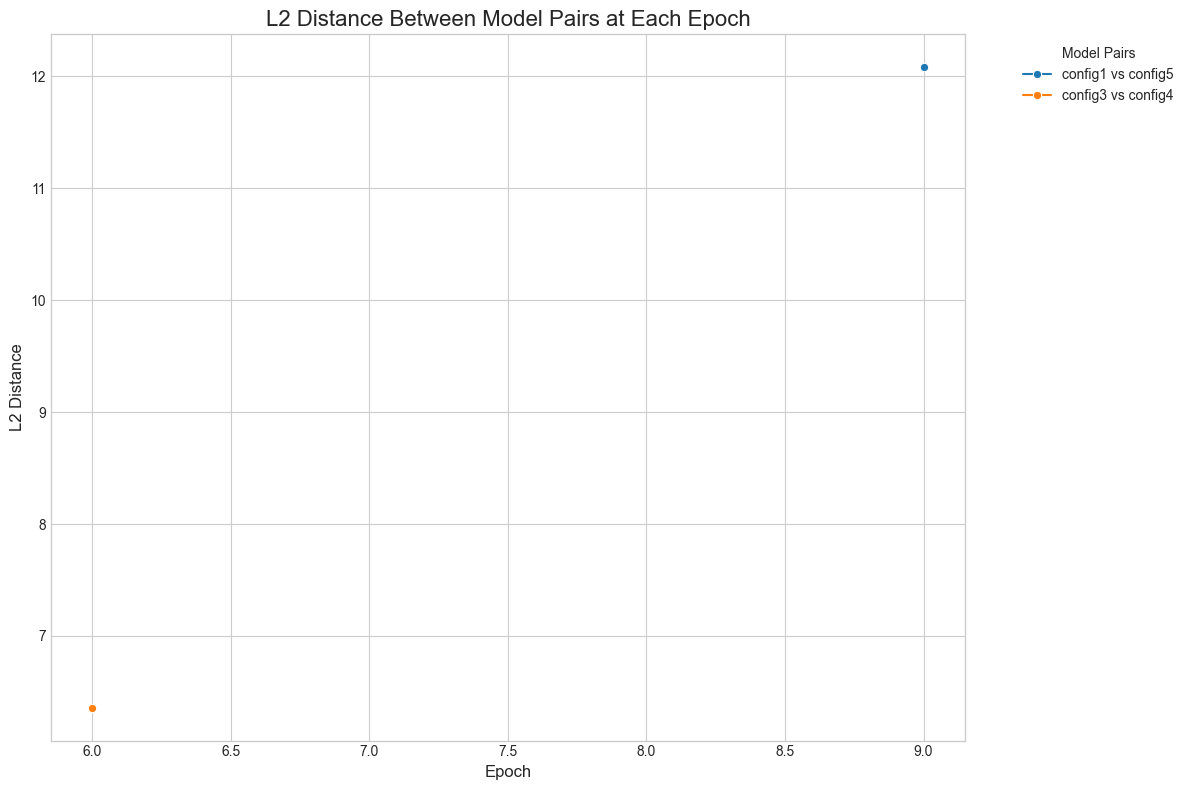

<Figure size 640x480 with 0 Axes>

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for pairs of different models at the same epoch
same_epoch_df = df_results[df_results['model1_epoch'] == df_results['model2_epoch']].copy()
same_epoch_df['model_pair'] = same_epoch_df.apply(lambda r: f"{r['model1_name']} vs {r['model2_name']}", axis=1)

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=same_epoch_df,
    x='model1_epoch',
    y='l2_distance',
    hue='model_pair',
    marker='o',
    ax=ax
)

ax.set_title('L2 Distance Between Model Pairs at Each Epoch', fontsize=16)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('L2 Distance', fontsize=12)
ax.legend(title='Model Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)

plt.tight_layout()
plt.show()
plt.savefig(f'{DRIVE_DIR}/pair_distance_per_epoch.png')

## Model soup performance (on test split) -  pairs of models

Individual Model Performance

In [14]:
# Evaluate each individual model at each epoch on both train and test splits.
individual_accuracies = []
for model_info in tqdm(Model_ids, desc="Evaluating Individual Models"):
    sd = load_model_sd(**model_info)
    if sd is None:
        continue
    model = get_model_from_sd(sd, Base_model)
    
    # Evaluate on test split
    test_acc = eval_model_on_dataset(model, Test_loader)
    
    # Evaluate on train split
    train_acc = eval_model_on_dataset(model, Train_loader)
    
    individual_accuracies.append({
        'name': model_info['name'],
        'epoch': model_info['epoch'],
        'test_accuracy': test_acc,
        'train_accuracy': train_acc
    })

df_individual_acc = pd.DataFrame(individual_accuracies)
print("✅ Individual model accuracies calculated.")
df_individual_acc.head()

Evaluating Individual Models:   0%|          | 0/110 [00:00<?, ?it/s]

[0% 0/1]	Acc: 60.00	Data (t) 3.522	Batch (t) 3.721
[0% 0/4]	Acc: 90.62	Data (t) 3.038	Batch (t) 3.468
[0% 0/1]	Acc: 60.00	Data (t) 2.717	Batch (t) 2.921
[0% 0/4]	Acc: 96.88	Data (t) 3.060	Batch (t) 3.478
[0% 0/1]	Acc: 70.00	Data (t) 3.160	Batch (t) 3.323
[0% 0/4]	Acc: 96.88	Data (t) 2.871	Batch (t) 3.290
[0% 0/1]	Acc: 70.00	Data (t) 3.105	Batch (t) 3.263
[0% 0/4]	Acc: 96.88	Data (t) 2.811	Batch (t) 3.211
[0% 0/1]	Acc: 50.00	Data (t) 2.931	Batch (t) 3.113
[0% 0/4]	Acc: 96.88	Data (t) 2.882	Batch (t) 3.264
✅ Individual model accuracies calculated.


,name,epoch,test_accuracy,train_accuracy
0,config1,0,0.6,0.84
1,config1,9,0.6,0.99
2,config3,6,0.7,0.99
3,config4,6,0.7,0.98
4,config5,9,0.5,0.99


In [15]:
# Merge individual accuracies into the main DataFrame
df_results = df_results.merge(
    df_individual_acc,
    left_on=['model1_name', 'model1_epoch'],
    right_on=['name', 'epoch']
).rename(columns={
    'test_accuracy': 'model1_test_accuracy',
    'train_accuracy': 'model1_train_accuracy'
}).drop(columns=['name', 'epoch'])

df_results = df_results.merge(
    df_individual_acc,
    left_on=['model2_name', 'model2_epoch'],
    right_on=['name', 'epoch']
).rename(columns={
    'test_accuracy': 'model2_test_accuracy',
    'train_accuracy': 'model2_train_accuracy'
}).drop(columns=['name', 'epoch'])

# Calculate mean accuracies for both splits
df_results['mean_test_accuracy'] = (df_results['model1_test_accuracy'] + df_results['model2_test_accuracy']) / 2
df_results['mean_train_accuracy'] = (df_results['model1_train_accuracy'] + df_results['model2_train_accuracy']) / 2

print("✅ Individual accuracies merged and mean accuracies calculated.")
df_results.head()

✅ Individual accuracies merged and mean accuracies calculated.


,model1_name,model1_epoch,model2_name,model2_epoch,l2_distance,model1_test_accuracy,model1_train_accuracy,model2_test_accuracy,model2_train_accuracy,mean_test_accuracy,mean_train_accuracy
0,config1,0,config3,6,1.620858,0.6,0.84,0.7,0.99,0.65,0.915
1,config1,9,config3,6,11.513184,0.6,0.99,0.7,0.99,0.65,0.990
2,config1,0,config4,6,6.496584,0.6,0.84,0.7,0.98,0.65,0.910
3,config1,9,config4,6,12.496667,0.6,0.99,0.7,0.98,0.65,0.985
4,config3,6,config4,6,6.351644,0.7,0.99,0.7,0.98,0.70,0.985


Compute soup accuracy for each pair

In [16]:
def create_soup(state_dicts, weights=None):
    """Create a model soup by averaging state dicts with given weights"""
    if weights is None:
        weights = [1.0 / len(state_dicts)] * len(state_dicts)

    # Start with the first model weighted
    soup_state_dict = {k: v.clone() * weights[0] for k, v in state_dicts[0].items()}

    # Add remaining models
    for i, state_dict in enumerate(state_dicts[1:], 1):
        for k, v in state_dict.items():
            soup_state_dict[k] += v.clone() * weights[i]

    return soup_state_dict


In [17]:
soup_test_accuracies = []
soup_train_accuracies = []

for _, row in tqdm(df_results.iterrows(), total=len(df_results), desc="Evaluating Soups"):
    sd1 = load_model_sd(row['model1_name'], row['model1_epoch'])
    sd2 = load_model_sd(row['model2_name'], row['model2_epoch'])
    
    if sd1 is None or sd2 is None:
        continue

    # Create a soup model:  theta = 1/2(theta_i + theta_j)
    soup_sd = create_soup([sd1, sd2])
    soup_model = get_model_from_sd(soup_sd, Base_model)
    
    # Evaluate the soup on test split
    test_acc = eval_model_on_dataset(soup_model, Test_loader)
    soup_test_accuracies.append(test_acc)
    
    # Evaluate the soup on train split
    train_acc = eval_model_on_dataset(soup_model, Train_loader)
    soup_train_accuracies.append(train_acc)

Evaluating Soups:   0%|          | 0/9 [00:00<?, ?it/s]

[0% 0/1]	Acc: 60.00	Data (t) 3.123	Batch (t) 3.281
[0% 0/4]	Acc: 96.88	Data (t) 3.150	Batch (t) 3.812
[0% 0/1]	Acc: 80.00	Data (t) 3.377	Batch (t) 3.662
[0% 0/4]	Acc: 96.88	Data (t) 3.049	Batch (t) 3.599
[0% 0/1]	Acc: 60.00	Data (t) 3.213	Batch (t) 3.392
[0% 0/4]	Acc: 96.88	Data (t) 3.030	Batch (t) 3.580
[0% 0/1]	Acc: 70.00	Data (t) 3.133	Batch (t) 3.295
[0% 0/4]	Acc: 100.00	Data (t) 3.041	Batch (t) 3.499
[0% 0/1]	Acc: 60.00	Data (t) 3.320	Batch (t) 3.507
[0% 0/4]	Acc: 93.75	Data (t) 2.978	Batch (t) 3.581
[0% 0/1]	Acc: 60.00	Data (t) 3.187	Batch (t) 3.368
[0% 0/4]	Acc: 96.88	Data (t) 3.056	Batch (t) 3.766
[0% 0/1]	Acc: 70.00	Data (t) 3.308	Batch (t) 3.480
[0% 0/4]	Acc: 96.88	Data (t) 2.976	Batch (t) 3.398
[0% 0/1]	Acc: 60.00	Data (t) 3.190	Batch (t) 3.476
[0% 0/4]	Acc: 96.88	Data (t) 2.892	Batch (t) 3.319
[0% 0/1]	Acc: 70.00	Data (t) 3.363	Batch (t) 3.559
[0% 0/4]	Acc: 96.88	Data (t) 3.022	Batch (t) 3.538


In [18]:
df_results['soup_test_accuracy'] = soup_test_accuracies
df_results['soup_train_accuracy'] = soup_train_accuracies

# Calculate soup improvements for both splits
df_results['soup_test_improvement'] = df_results['soup_test_accuracy'] - df_results['mean_test_accuracy']
df_results['soup_train_improvement'] = df_results['soup_train_accuracy'] - df_results['mean_train_accuracy']

print("✅ Soup accuracies calculated and added to DataFrame.")
df_results.head()

✅ Soup accuracies calculated and added to DataFrame.


,model1_name,model1_epoch,model2_name,model2_epoch,l2_distance,model1_test_accuracy,model1_train_accuracy,model2_test_accuracy,model2_train_accuracy,mean_test_accuracy,mean_train_accuracy,soup_test_accuracy,soup_train_accuracy,soup_test_improvement,soup_train_improvement
0,config1,0,config3,6,1.620858,0.6,0.84,0.7,0.99,0.65,0.915,0.6,0.95,-0.05,0.035
1,config1,9,config3,6,11.513184,0.6,0.99,0.7,0.99,0.65,0.990,0.8,0.99,0.15,0.000
2,config1,0,config4,6,6.496584,0.6,0.84,0.7,0.98,0.65,0.910,0.6,0.96,-0.05,0.050
3,config1,9,config4,6,12.496667,0.6,0.99,0.7,0.98,0.65,0.985,0.7,1.00,0.05,0.015
4,config3,6,config4,6,6.351644,0.7,0.99,0.7,0.98,0.70,0.985,0.6,0.97,-0.10,-0.015


Save all results

In [19]:
df_results.to_csv(f'{DRIVE_DIR}/pair_soup_acc-pair_distance.csv', index=False)

### Plot: soup accuracy(epoch)
soup for every pair of models at same epoch.

In [20]:
df_results = pd.read_csv(f'{DRIVE_DIR}/pair_soup_acc-pair_distance.csv')

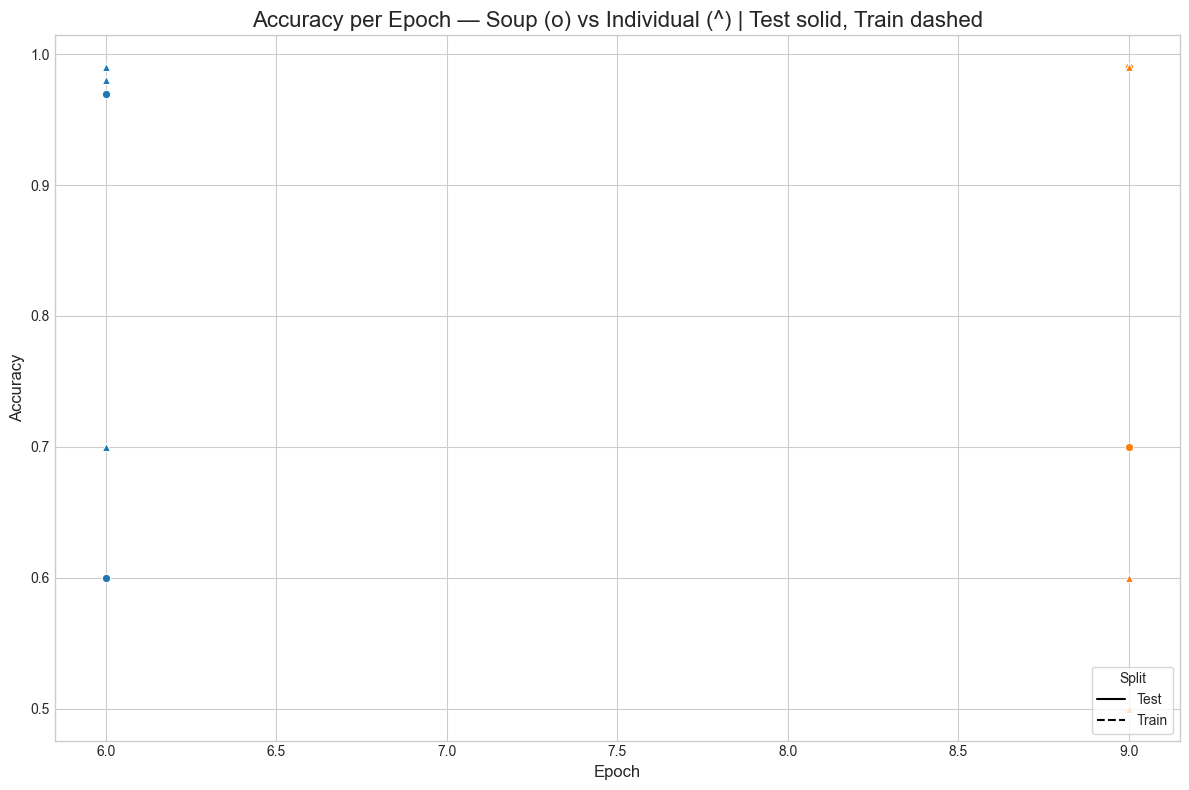

<Figure size 640x480 with 0 Axes>

In [25]:
# Filter for pairs of different models at the same epoch
same_epoch_df = df_results[df_results['model1_epoch'] == df_results['model2_epoch']].copy()
same_epoch_df['model_pair'] = same_epoch_df.apply(lambda r: f"{r['model1_name']} vs {r['model2_name']}", axis=1)

# msk = same_epoch_df['model_pair'] == 'config2 vs config4'
# same_epoch_df = same_epoch_df[msk]

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Test (solid)
sns.lineplot(
    data=same_epoch_df,
    x='model1_epoch',
    y='soup_test_accuracy',
    hue='model_pair',
    marker='o',
    linestyle='-',
    ax=ax
)
sns.lineplot(
    data=same_epoch_df,
    x='model1_epoch',
    y='model1_test_accuracy',
    hue='model_pair',
    marker='^',
    linestyle='-',
    legend=False,
    ax=ax
)
sns.lineplot(
    data=same_epoch_df,
    x='model1_epoch',
    y='model2_test_accuracy',
    hue='model_pair',
    marker='^',
    linestyle='-',
    legend=False,
    ax=ax
)

# Train (dashed)
sns.lineplot(
    data=same_epoch_df,
    x='model1_epoch',
    y='soup_train_accuracy',
    hue='model_pair',
    marker='o',
    linestyle='--',
    legend=False,
    ax=ax
)
sns.lineplot(
    data=same_epoch_df,
    x='model1_epoch',
    y='model1_train_accuracy',
    hue='model_pair',
    marker='^',
    linestyle='--',
    legend=False,
    ax=ax
)
sns.lineplot(
    data=same_epoch_df,
    x='model1_epoch',
    y='model2_train_accuracy',
    hue='model_pair',
    marker='^',
    linestyle='--',
    legend=False,
    ax=ax
)

ax.set_title('Accuracy per Epoch — Soup (o) vs Individual (^) | Test solid, Train dashed', fontsize=16)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)

from matplotlib.lines import Line2D
pair_legend = ax.legend(title='Model Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.add_artist(pair_legend)
style_handles = [
    Line2D([0], [0], color='k', linestyle='-', label='Test'),
    Line2D([0], [0], color='k', linestyle='--', label='Train'),
]
ax.legend(handles=style_handles, title='Split', loc='lower right', frameon=True)

ax.grid(True)
plt.tight_layout()
plt.show()
plt.savefig(f'{DRIVE_DIR}/soup_accuracy_pairs_per_epoch.png')

## Relation between Soup performance and model L2 distance

### Plot: soup improvement vs L2 distance

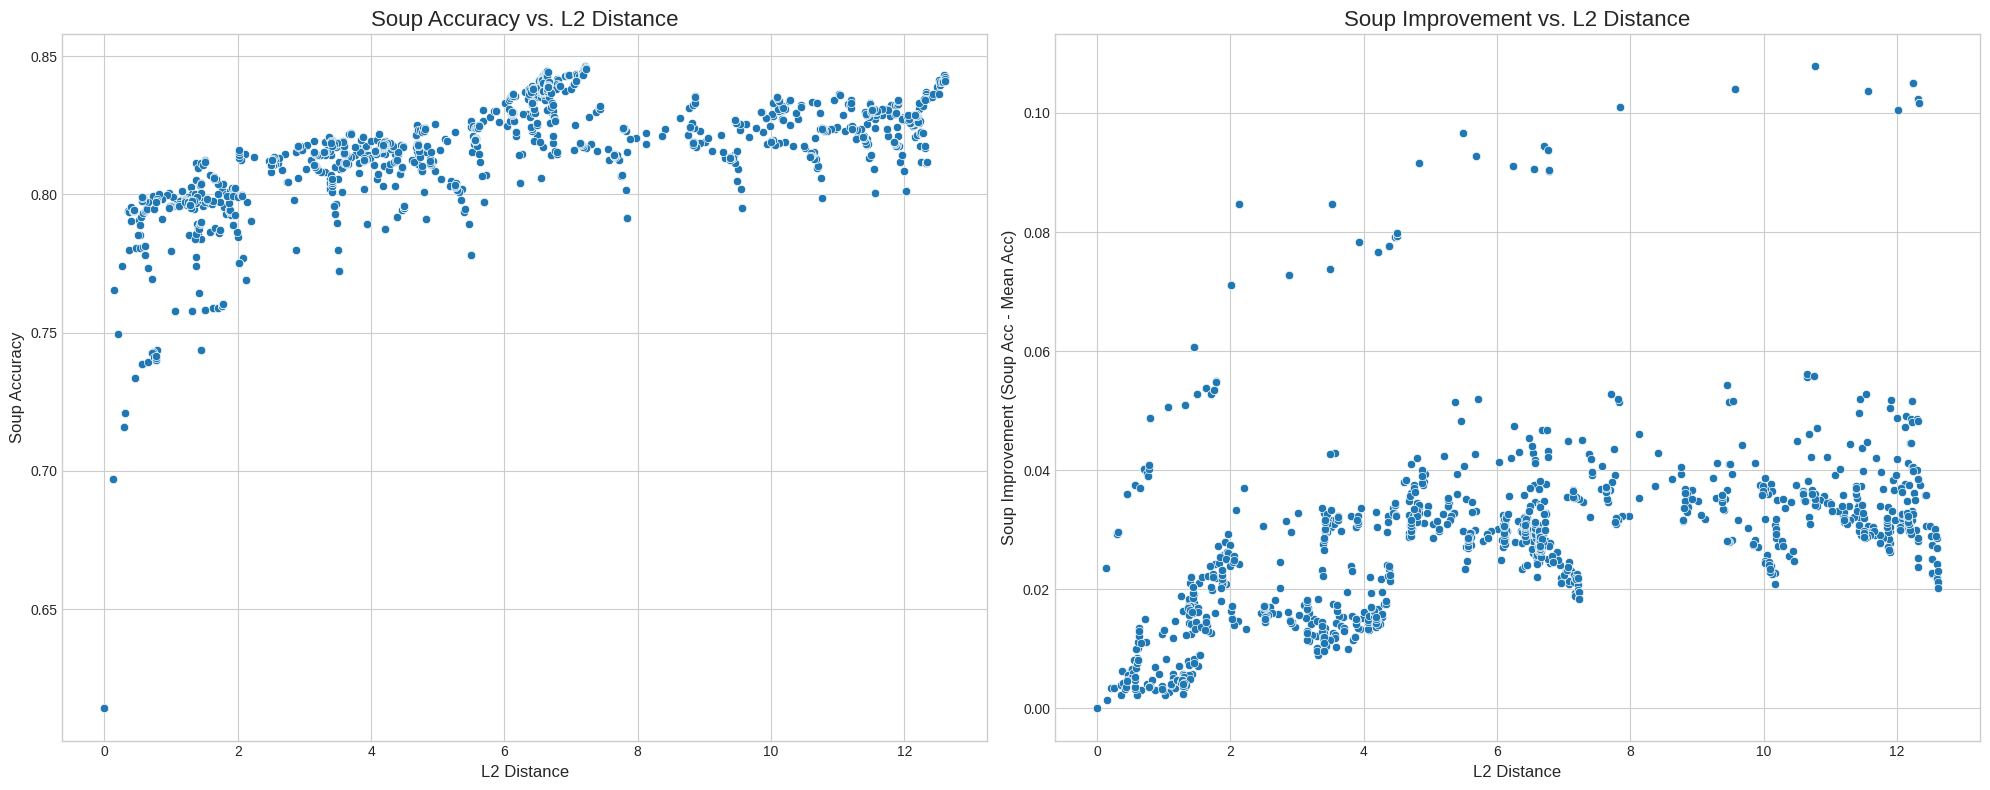

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot 1: Soup Accuracy vs. L2 Distance
sns.scatterplot(
    data=df_results,
    x='l2_distance',
    y='soup_accuracy',
    ax=axes[0]
)
axes[0].set_title('Soup Accuracy vs. L2 Distance', fontsize=16)
axes[0].set_xlabel('L2 Distance', fontsize=12)
axes[0].set_ylabel('Soup Accuracy', fontsize=12)

# Plot 2: Soup Improvement vs. L2 Distance
sns.scatterplot(
    data=df_results,
    x='l2_distance',
    y='soup_improvement',
    ax=axes[1]
)
axes[1].set_title('Soup Improvement vs. L2 Distance', fontsize=16)
axes[1].set_xlabel('L2 Distance', fontsize=12)
axes[1].set_ylabel('Soup Improvement (Soup Acc - Mean Acc)', fontsize=12)

plt.tight_layout()
plt.show()
plt.savefig(f'{DRIVE_DIR}/soup_accuracy_vs_pair_distance.png')

In [ ]:
import pandas as pd
df_results = pd.read_csv(f'{DRIVE_DIR}/pair_soup_acc-pair_distance.csv')

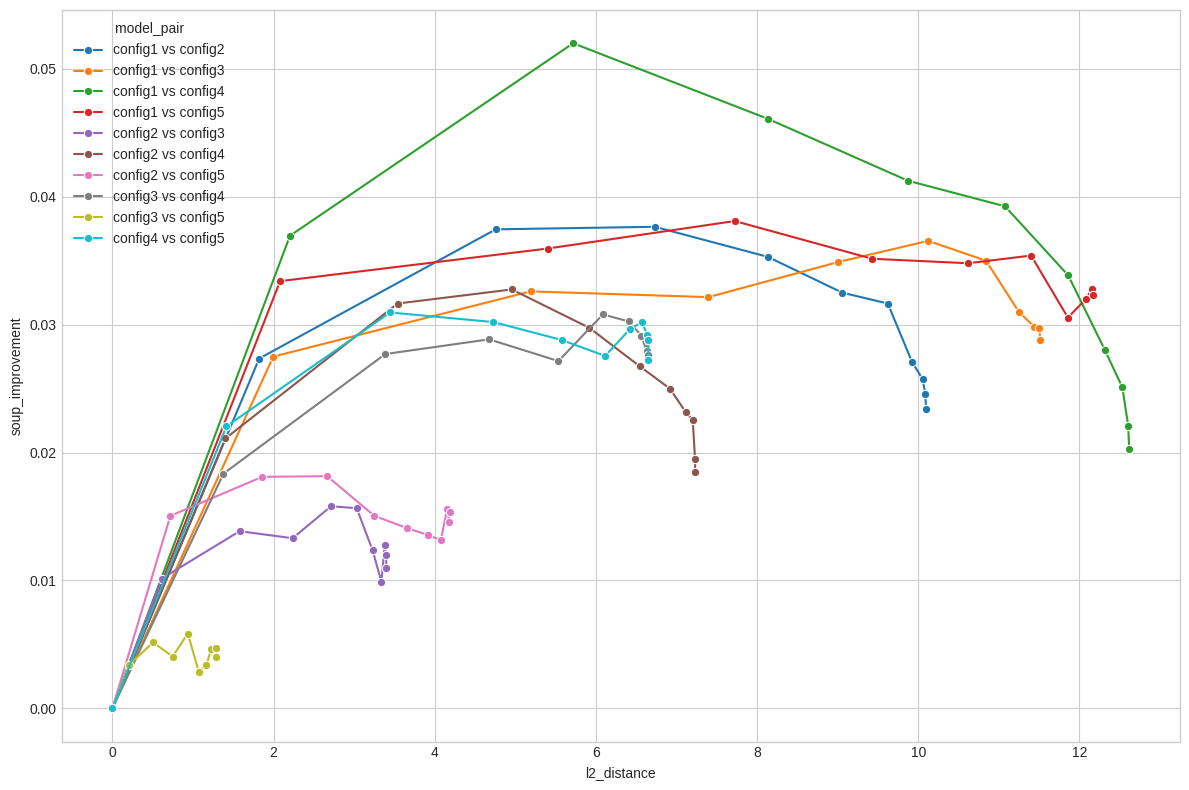

In [ ]:
# Filter for pairs of different models at the same epoch
same_epoch_df = df_results[df_results['model1_epoch'] == df_results['model2_epoch']].copy()
same_epoch_df['model_pair'] = same_epoch_df.apply(lambda r: f"{r['model1_name']} vs {r['model2_name']}", axis=1)

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=same_epoch_df,
    x='l2_distance',
    y='soup_improvement',
    hue='model_pair',
    marker='o',
    ax=ax
)

# ax.set_title('Soup (o) and Mean (x) Accuracy of Model Pairs at Each Epoch', fontsize=16)
# ax.set_xlabel('Epoch', fontsize=12)
# ax.set_ylabel('Test Accuracy', fontsize=12)
# ax.legend(title='Model Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.grid(True)

plt.tight_layout()
plt.show()
# plt.savefig(f'{DRIVE_DIR}/soup_accuracy_pairs_per_epoch.png')

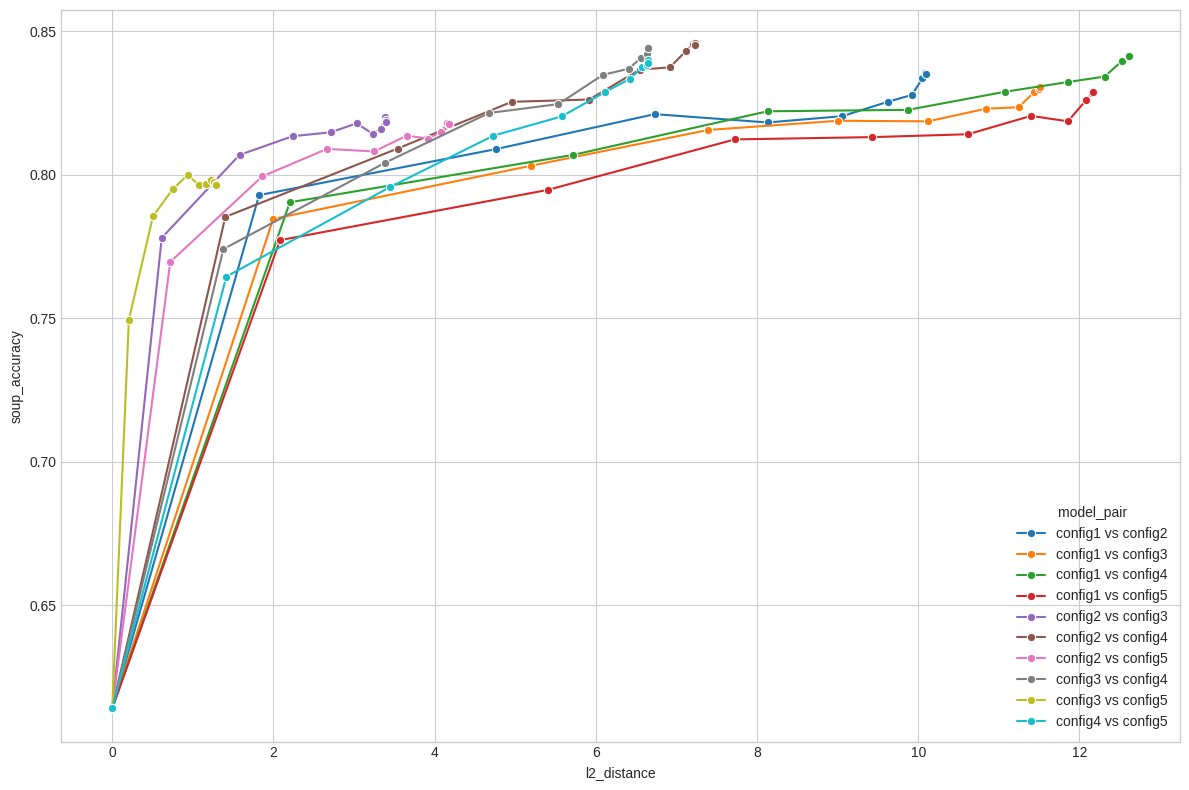

In [ ]:
# Filter for pairs of different models at the same epoch
same_epoch_df = df_results[df_results['model1_epoch'] == df_results['model2_epoch']].copy()
same_epoch_df['model_pair'] = same_epoch_df.apply(lambda r: f"{r['model1_name']} vs {r['model2_name']}", axis=1)

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=same_epoch_df,
    x='l2_distance',
    y='soup_accuracy',
    hue='model_pair',
    marker='o',
    ax=ax
)


sns.lineplot(
    data=same_epoch_df,
    x='l2_distance',
    y=' model1_',
    hue='model_pair',
    marker='o',
    ax=ax
)


# ax.set_title('Soup (o) and Mean (x) Accuracy of Model Pairs at Each Epoch', fontsize=16)
# ax.set_xlabel('Epoch', fontsize=12)
# ax.set_ylabel('Test Accuracy', fontsize=12)
# ax.legend(title='Model Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.grid(True)

plt.tight_layout()
plt.show()
# plt.savefig(f'{DRIVE_DIR}/soup_accuracy_pairs_per_epoch.png')